In [1]:
import polars as pl
import numpy as np
from pathlib import Path
import h3pandas
from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
# Define the input directory and get the list of parquet files
input_dir = Path('../data/output')
output_dir = Path('../data/output-joining')

c_files = list(input_dir.glob('continuous*.parquet'))
c_output = output_dir / 'raster_combined-continuous.parquet'


In [3]:
#Functions

def is_prime(n):
    if n <= 1:
        return 0
    if n <= 3:
        return 1
    if n % 2 == 0 or n > 2:
        return 0
    return 1 if all(n % i for i in range(3, int(np.sqrt(n)) + 1, 2)) else 0

def scale_values(values):
    scaled_values =(values * 100).floor()
    return scaled_values

def process_file(i, file):
    """Processes a single file, scaling values and checking for primes."""
    # Read the parquet file
    df = pl.read_parquet(file)
    
    # Scale the "value" column
    scaled_values = scale_values(df["value"])
    
    # Check if the scaled value is a prime number
    primes = scaled_values.map_elements(lambda x: is_prime(int(x)))
    
    # Add the prime boolean to the DataFrame
    df = df.with_columns([
        pl.Series(f"is_prime_{i}", primes)
    ])
    
    # Drop the original "value" column
    df = df.drop("value")
    
    return df

def classify(files, N):
    # Process files in parallel
    dfs = Parallel(n_jobs=-1)(delayed(process_file)(i, file) for i, file in enumerate(tqdm(files[:N], desc="Processing files")))

    final_df = dfs[0]

    # Join all DataFrames on the "h3_12" column
    for i, df in enumerate(tqdm(dfs[1:], desc="Joining DataFrames")):
        final_df = final_df.join(df, on="h3_12", how="outer_coalesce")

    return final_df

def summing(df):
    #Summing all columns 
    columns=df.columns
    sum_df=df.with_columns(sum=pl.sum_horizontal(columns[1:]))
    sum_df=sum_df[["h3_12","sum"]]
    return sum_df

In [4]:
%%time
# Process and classify the files
N = 10  
final_df = classify(c_files, N)
final_df = summing(final_df)

Joining DataFrames: 100%|██████████| 9/9 [00:00<00:00, 1500.17it/s]

CPU times: total: 15.6 ms
Wall time: 589 ms


CPU times: total: 125 ms
Wall time: 701 ms


<Axes: >

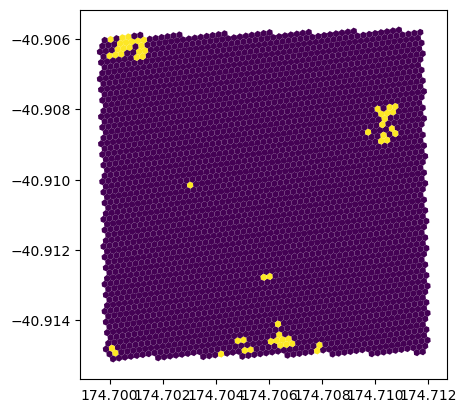

In [5]:
%%time 
#drawing the h3 geometries is neglegible
pdf=final_df.to_pandas()
pdf=pdf.set_index("h3_12").h3.h3_to_geo_boundary()
pdf.plot('sum')

In [6]:
%%time
# Process and classify the files
N = 100
final_df = classify(c_files, N)
final_df = summing(final_df)

Joining DataFrames: 100%|██████████| 99/99 [00:00<00:00, 2015.61it/s]

CPU times: total: 46.9 ms
Wall time: 251 ms


CPU times: total: 62.5 ms
Wall time: 432 ms


<Axes: >

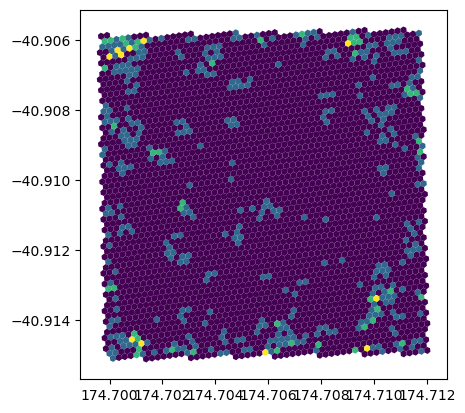

In [7]:
%%time 
#drawing the h3 geometries is neglegible
pdf=final_df.to_pandas()
pdf=pdf.set_index("h3_12").h3.h3_to_geo_boundary()
pdf.plot('sum')

In [8]:
%%time
# Process and classify the files
N = 1000  
final_df = classify(c_files, N)
final_df = summing(final_df)

Joining DataFrames: 100%|██████████| 999/999 [00:01<00:00, 697.45it/s] 

CPU times: total: 1.64 s
Wall time: 2.16 s


CPU times: total: 93.8 ms
Wall time: 421 ms


<Axes: >

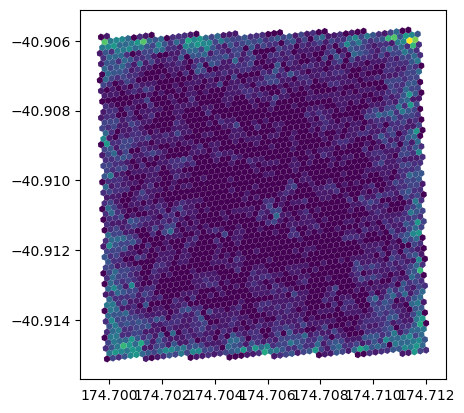

In [9]:
%%time 
#drawing the h3 geometries is neglegible
pdf=final_df.to_pandas()
pdf=pdf.set_index("h3_12").h3.h3_to_geo_boundary()
pdf.plot('sum')

In [10]:
%%time
# Process and classify the files
N = 10000  
final_df = classify(c_files, N)
final_df = summing(final_df)

Joining DataFrames: 100%|██████████| 9999/9999 [02:12<00:00, 75.43it/s] 

CPU times: total: 9min 33s
Wall time: 2min 18s


CPU times: total: 62.5 ms
Wall time: 419 ms


<Axes: >

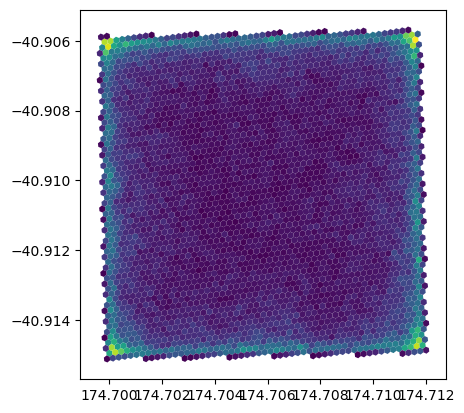

In [11]:
%%time 
#drawing the h3 geometries is neglegible
pdf=final_df.to_pandas()
pdf=pdf.set_index("h3_12").h3.h3_to_geo_boundary()
pdf.plot('sum')

In [12]:
pdf.to_parquet(c_output)